<a href="https://colab.research.google.com/github/jtunde/Python/blob/main/s2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math
from sklearn.metrics import accuracy_score

In [1]:
def proc_categ(values):
    categ = values.value_counts()
    count = float(len(values))
    res = ""
    for idx in categ.index:
        res += idx
        res += " " + str(categ[idx]) + " " + str(100*round(categ[idx] / count,4)) + "%, "
    return res

def example_plot(normal_values, attack_values):
    # Plot a selection of features
    fig, axs = plt.subplots(3, 2)

    # The first column will plot the normal, the second the attack
    axs[0, 0].plot(normal_values[37])#dst_host_serror_rate
    axs[0, 0].set_title('Normal: % dest. connections with SYN errors')
    axs[0, 1].plot(attack_values[37])#dst_host_serror_rate
    axs[0, 1].set_title('Attack: % dest. connections with SYN errors')

    axs[1, 0].plot(normal_values[24])#serror_rate
    axs[1, 0].set_title('Normal: % connections with SYN errors')
    axs[1, 1].plot(attack_values[24])#serror_rate
    axs[1, 1].set_title('Attack: % connections with SYN errors')

    axs[2, 0].plot(normal_values[4])#src_bytes
    axs[2, 0].set_title('Normal: src bytes')
    axs[2, 1].plot(attack_values[4])#src_bytes
    axs[2, 1].set_title('Attack: src bytes')

    plt.show()

nls_columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'class']

CLASSIFIER_COLUMN = 41


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('drive/MyDrive/KDDTrain+_20Percent.txt', header=None)

In [4]:
print(df[0:10])
print("Attack type statistics:" + proc_categ(df[41]))
print("Protocol statistics:" + proc_categ(df[1]))

   0    1           2    3    4     5   ...    37    38    39    40       41  42
0   0  tcp    ftp_data   SF  491     0  ...  0.00  0.00  0.05  0.00   normal  20
1   0  udp       other   SF  146     0  ...  0.00  0.00  0.00  0.00   normal  15
2   0  tcp     private   S0    0     0  ...  1.00  1.00  0.00  0.00  neptune  19
3   0  tcp        http   SF  232  8153  ...  0.03  0.01  0.00  0.01   normal  21
4   0  tcp        http   SF  199   420  ...  0.00  0.00  0.00  0.00   normal  21
5   0  tcp     private  REJ    0     0  ...  0.00  0.00  1.00  1.00  neptune  21
6   0  tcp     private   S0    0     0  ...  1.00  1.00  0.00  0.00  neptune  21
7   0  tcp     private   S0    0     0  ...  1.00  1.00  0.00  0.00  neptune  21
8   0  tcp  remote_job   S0    0     0  ...  1.00  1.00  0.00  0.00  neptune  21
9   0  tcp     private   S0    0     0  ...  1.00  1.00  0.00  0.00  neptune  21

[10 rows x 43 columns]
Attack type statistics:normal 13449 53.39%, neptune 8282 32.879999999999995%, ipsweep

NORMAL data count: 13449
SYN data count: 8282


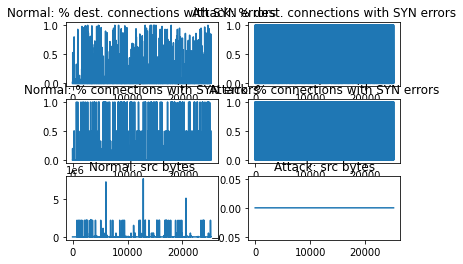

In [5]:
normal_val = df.loc[df[41] == 'normal']
syn_val = df.loc[df[41] == 'neptune']
print("NORMAL data count: " + str(len(normal_val)))
print("SYN data count: " + str(len(syn_val)))

example_plot(normal_val, syn_val)

In [6]:
def prepare_labels(df):
    categ = df[CLASSIFIER_COLUMN].value_counts()
    labels = {}
    ctr = 0
    for idx in categ.index:
        labels[idx] = ctr
        ctr += 1

        df.loc[(df[CLASSIFIER_COLUMN] == idx), CLASSIFIER_COLUMN] = ctr

    return df

# Place integer values in column 41 (the class column)
dflab = prepare_labels(df)
dflab[CLASSIFIER_COLUMN] = pd.to_numeric(dflab[CLASSIFIER_COLUMN]) # Make it numeric, so that it is not eliminated by the preprocessing!!!
print(dflab)

       0    1         2     3    4     5   ...    37    38    39    40  41  42
0       0  tcp  ftp_data    SF  491     0  ...  0.00  0.00  0.05  0.00   1  20
1       0  udp     other    SF  146     0  ...  0.00  0.00  0.00  0.00   1  15
2       0  tcp   private    S0    0     0  ...  1.00  1.00  0.00  0.00   2  19
3       0  tcp      http    SF  232  8153  ...  0.03  0.01  0.00  0.01   1  21
4       0  tcp      http    SF  199   420  ...  0.00  0.00  0.00  0.00   1  21
...    ..  ...       ...   ...  ...   ...  ...   ...   ...   ...   ...  ..  ..
25187   0  tcp      exec  RSTO    0     0  ...  0.00  0.00  1.00  1.00   2  19
25188   0  tcp  ftp_data    SF  334     0  ...  0.00  0.00  0.00  0.00  10  12
25189   0  tcp   private   REJ    0     0  ...  0.00  0.00  1.00  1.00   2  21
25190   0  tcp      nnsp    S0    0     0  ...  1.00  1.00  0.00  0.00   2  20
25191   0  tcp    finger    S0    0     0  ...  1.00  1.00  0.00  0.00   2  18

[25192 rows x 43 columns]


In [7]:
def preproc_data(df):
    # We delete columns with 0
    df = df.loc[:, (df != 0).any(axis=0)]

    # We delete columns with non-numeric values
    non_numerical = []
    for col in df:
        if not pd.api.types.is_numeric_dtype(df[col]):
            non_numerical.append(col)
    df = df.drop(columns=non_numerical)

    # Normalize columns - min-max normalization ([0,1] interval)
    for col in df:
        if col == CLASSIFIER_COLUMN: # Skip the classifier column
            continue
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    return df

# Remove last column - it contains traffic type, we do not care about that
dflab_proc = dflab.iloc[:,:(len(dflab.columns)-1)]

# Remove zeros and non-numeric columns
dflab_proc = preproc_data(dflab_proc)
print(dflab_proc)

        0             4         5    6    7   ...    37    38    39    40  41
0      0.0  1.286320e-06  0.000000  0.0  0.0  ...  0.00  0.00  0.05  0.00   1
1      0.0  3.824902e-07  0.000000  0.0  0.0  ...  0.00  0.00  0.00  0.00   1
2      0.0  0.000000e+00  0.000000  0.0  0.0  ...  1.00  1.00  0.00  0.00   2
3      0.0  6.077927e-07  0.001583  0.0  0.0  ...  0.03  0.01  0.00  0.01   1
4      0.0  5.213394e-07  0.000082  0.0  0.0  ...  0.00  0.00  0.00  0.00   1
...    ...           ...       ...  ...  ...  ...   ...   ...   ...   ...  ..
25187  0.0  0.000000e+00  0.000000  0.0  0.0  ...  0.00  0.00  1.00  1.00   2
25188  0.0  8.750119e-07  0.000000  0.0  0.0  ...  0.00  0.00  0.00  0.00  10
25189  0.0  0.000000e+00  0.000000  0.0  0.0  ...  0.00  0.00  1.00  1.00   2
25190  0.0  0.000000e+00  0.000000  0.0  0.0  ...  1.00  1.00  0.00  0.00   2
25191  0.0  0.000000e+00  0.000000  0.0  0.0  ...  1.00  1.00  0.00  0.00   2

[25192 rows x 37 columns]


In [8]:
# Prepare dataset for training and for testing
df_train = dflab_proc.iloc[0:(int(len(dflab_proc.index)/2)),:]
df_pred = dflab_proc.iloc[(int(len(dflab_proc.index)/2)):,:]

In [9]:
# Create model
def rand_forest_fit(dfin):
    # Perform a random forest-based classification
    rf = RandomForestClassifier(n_estimators = 200, random_state = 42, max_depth = 30, min_samples_leaf = 4, min_samples_split = 5, oob_score = True)

    # Prepare the data
    data_arr = dfin.to_numpy()
    nb_cols = numpy.shape(data_arr)[1]

    train_data = data_arr[:,0:(nb_cols-2)]
    label_data = data_arr[:,nb_cols-1]

    print(label_data)

    # Now train the model
    rf.fit(train_data, label_data)

    # Show importance
    features = dfin.columns.to_numpy()
    features = features[0:-1] # Delete last column - not used as a feature
    feat_imp = rf.feature_importances_

    feat_sig = [a for a in zip(feat_imp, features)]
    # Sort by importance
    feat_sig.sort(reverse=True,key = lambda x: x[0])

    print("IMPORTANCES: ")
    for sig, feat in feat_sig:
        print("{} : {}".format(nls_columns[feat], sig))

    return rf

# Train the model
rf_model = rand_forest_fit(df_train)

[1. 1. 2. ... 2. 1. 1.]
IMPORTANCES: 
same_srv_rate : 0.11723286610654304
diff_srv_rate : 0.10172233244783924
dst_host_serror_rate : 0.07676448784556224
dst_bytes : 0.06432620485844344
count : 0.06193630404204126
dst_host_srv_count : 0.055942167704680426
serror_rate : 0.05574323329471942
dst_host_srv_serror_rate : 0.05443354383802578
dst_host_same_src_port_rate : 0.05259779736272492
dst_host_diff_srv_rate : 0.04336535789866115
dst_host_same_srv_rate : 0.03869939479223708
dst_host_srv_diff_host_rate : 0.03621416140131757
srv_serror_rate : 0.03469590310935848
srv_count : 0.03344586893417833
logged_in : 0.026518214562739884
dst_host_count : 0.025241046663214917
dst_host_rerror_rate : 0.02487727614124243
rerror_rate : 0.024616092552607508
src_bytes : 0.020412153017642244
srv_rerror_rate : 0.015839509274511835
wrong_fragment : 0.011534713678680177
srv_diff_host_rate : 0.007760683106105023
hot : 0.006260459967520126
num_compromised : 0.004707555924557807
duration : 0.003980246805991446
is_gu

Mean Absolute Error: 0.0581 degrees.


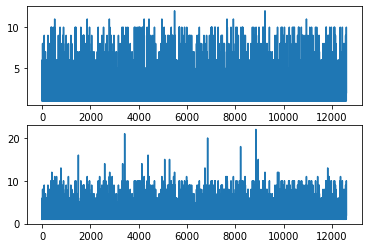

In [10]:
def rand_forest_predict(rf, df):
    # Prepare the data
    data_arr = df.to_numpy()
    nb_cols = numpy.shape(data_arr)[1]

    predict_data = data_arr[:,0:(nb_cols-2)]
    label_data = data_arr[:,(nb_cols-1)]

    prediction = rf.predict(predict_data)
    errors = abs(prediction - label_data)

    print('Mean Absolute Error:', round(numpy.mean(errors), 4), 'degrees.')

    # Plot a selection of features
    fig, axs = plt.subplots(2)

    axs[0].plot(prediction)
    axs[1].plot(label_data)
    plt.show()

# Now predict
rand_forest_predict(rf_model, df_pred)

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
#X = 10 * np.random.randn(100, 2) + 6
kmeans_model = KMeans(n_clusters=3, random_state=1)
kmeans_model.fit(df_train)
labels = kmeans_model.labels_
s = metrics.silhouette_score(df_train, labels, metric='euclidean')
print(s)

0.5266005661290648


In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train)
X_test = scaler.transform(df_pred)

In [21]:
K_cent= 8
km= KMeans(n_clusters= K_cent, max_iter= 100)
km.fit(X_train)
cent= km.cluster_centers_

In [22]:
max=0 
for i in range(K_cent):
	for j in range(K_cent):
		d= np.linalg.norm(cent[i]-cent[j])
		if(d> max):
			max= d
d= max

sigma= d/math.sqrt(2*K_cent)

In [23]:
shape= X_train.shape
row= shape[0]
column= K_cent
G= np.empty((row,column), dtype= float)

In [24]:
for i in range(row):
  for j in range(column):
    dist= np.linalg.norm(X_train[i]-cent[j])
    G[i][j]= math.exp(-math.pow(dist,2)/math.pow(2*sigma,2))

In [25]:
GTG= np.dot(G.T,G)
GTG_inv= np.linalg.inv(GTG)
fac= np.dot(GTG_inv,G.T)
W= np.dot(fac,X_train)

In [26]:
row= X_test.shape[0]
column= K_cent
G_test= np.empty((row,column), dtype= float)
for i in range(row):
	for j in range(column):
		dist= np.linalg.norm(X_test[i]-cent[j])
		G_test[i][j]= math.exp(-math.pow(dist,2)/math.pow(2*sigma,2))

In [31]:
prediction= np.dot(G_test,W)
prediction= 0.5*(np.sign(prediction-0.5)+1)

score= accuracy_score(prediction,_pred)
print(score.mean())

NameError: ignored